## Fake Data Config

The fake channels, companies and products to generate data for.

In [1]:
import random
import uuid
import copy
import asammdf
import numpy as np
import os
import io
import fsspec

channels = {
    "engine_speed": "rpm",
    "engine_speed_desired": "rpm",
    "vehicle_speed": "kph",
    "coolant_temp": "C",
    "longitude": "",
    "latitude": "",
    "power": "W",
    "efficiency": "W",
    "ADAS5_failure": "bool",
    "X": "",
    "Y": "",
    "Z": "",
}

companies = [
    "DäsCarGmbh",
    "HeavyEquipmentInc",
    "DanishStartup",
    "ABMøøse",
    "재벌",
]
products = [
    "Car",
    "IndustrialEngine",
    "Bulldozer",
    "DumpTruck",
    "Excavator",
    "Transmission",
    "BoatyMcBoatface",
    "MarsColonizer",
]

Simplified signal generators to use for channel signal:

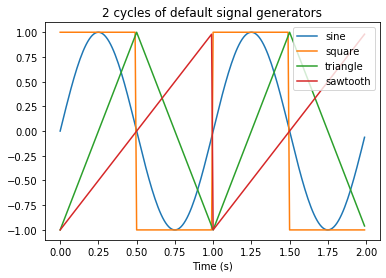

In [2]:
import scipy as sp
import scipy.signal
# Simplified signals
def sine(t, A=1, f=1):
    sine_ = A * np.sin(
        2 * np.pi * f * t
    )
    return sine_
def square(t, A=1, f=1):
    square_ = A * scipy.signal.square(
        2 * np.pi * f * t
    )
    return square_
def triangle(t, A=1, f=1):
    triangle_ = A * sp.signal.sawtooth(2 * np.pi * f * t, width=0.5)
    return triangle_
def sawtooth(t, A=1, f=1):
    sawtooth_ = A * sp.signal.sawtooth(2 * np.pi * f * t, width=1)
    return sawtooth_
signal_generators = [sine, square, triangle, sawtooth]

%matplotlib inline
import matplotlib.pyplot as plt
f=100
T0=0
Tf=2
t = np.arange(T0, Tf, 1/f)
for signal_generator in signal_generators:
    plt.plot(t, signal_generator(t))
plt.legend([sg.__name__ for sg in signal_generators], loc="upper right")
plt.xlabel("Time (s)")
plt.title("2 cycles of default signal generators");

Configure the specifics of the MDF file settings:

In [3]:
# Versions of MDF to save data as.
versions = [
    '4.00',
    '4.10',
    '4.11',
]

In [4]:
# How much data should be in each MDF file?
Tfs = [86400, 86400/2, 86400/4, 86400/12] # [s] "Big" data. Does not work on binder
Tfs = [60, 600, 1800] # [s] "Tiny" data.
# What is the sampling rate of the data?
Tss = [1, 0.1, 0.01] # [s]

In [5]:
import fsspec
import os
s3_cfg = {
    "key": "mdf_minio_access_key",
    "secret": "mdf_minio_secret_key",
    "client_kwargs": {
        "endpoint_url": "http://minio:9000",
    },
}
fs = fsspec.filesystem("s3", **s3_cfg)
buckets = fs.ls("")

print(f"Buckets: {fs.ls('')}")

Buckets: ['test']


In [6]:
buckets=list()
for bucket in range(10):
    try:
        bucket=f"mdfbucket-{bucket}"
        buckets.append(bucket)
        fs.mkdir(bucket)
    except FileExistsError:
        pass    

# Signals Generator

Generate signals for the MDF file.

In [7]:
def drylab_signals():
    """
    Generate a list of "real world" based on the channels variable.
    
    Also adds 'gems' to find when starting data mining.
    
    
    """
    
    # Randomly pick sampling rate and total log duration from the lists
    Tf = random.choice(Tfs)
    Ts = random.choice(Tss)
    
    # Create a timestamps vector.
    timestamps = np.arange(0, Tf, Ts, dtype=np.float32)
    
    
    ## Introduce Errors to logs.
    # Code written to generate "bad" data so we can
    # Write code to find bad data
    
    # Copy the channel list to another list for this MDF.
    channels2 = copy.deepcopy(channels)
    
    # Try 5x times to "win" a 
    for _ in range(5):
        # 2.5% chance of dropping a channel:
        if random.random()<0.025:
            # Pick one at random.
            dropped_channel = random.choice(list(channels2.keys()))
            # Drop it.
            channels2.pop(dropped_channel)

    # Create a list for signals.
    signals = list()
    for channel_name, channel_unit in channels2.items():
        ## Add noise
        # The mean for the amplitude center.
        loc = random.choice([250, 500, 750, 1000])
        # How much is the a scale for the amplitude.
        scale = random.choice([10, 25, 50, 100])
        # 
        A = np.random.normal(loc,scale)
        
        # Pick a frequency.
        f = np.abs(np.random.normal(1/(Ts*10), 1))
        
        # 5% Chance: Signal is flatlined at a number.
        if random.random()<0.05:
            Y=np.ones(np.size(timestamps))*random.choice([0, 500, 1000])
        else:
            Y = signal_generator(timestamps, A, f)
        # 5% Chance
        if random.random()<0.05:
            # How many bad samples?
            bad_samples = random.randint(0, len(Y))
            # Where to start the bad samples.
            bad_idx = random.randint(0, len(Y)-bad_samples)
            # Put in bad data.
            Y[bad_idx:bad_idx+bad_samples]=random.choice([0, 1000])
        # Create a MDF signal.
        signal_ = asammdf.Signal(
            samples=Y,
            timestamps=timestamps,
            name=channel_name,
            unit=channel_unit,
        )
        # Add it to the list.
        signals.append(signal_)
    # Return the list of signals.
    return signals

# MDF Generator

Generate an MDF file.

In [8]:
def drylab_mdf(*args, **kwargs):
    # Randomly pick a bucket to save to.
    bucket  = random.choice(buckets)
    # Randomly pick a company name the MDF belongs to.
    company = random.choice(companies)
    product = random.choice(products)
    # Globally unique mdf filename.
    data_file_uuid = str(uuid.uuid4())
    
    # Randomly pick a MDF version.
    version = random.choice(versions)
    
    # Get the datafile path.
    datafile = os.path.join(
        bucket,
        company,
        product,
        data_file_uuid
    )
    # Determine what suffix the datafile should have.
    if version.startswith("4"):
        datafile+=".mf4"
    else:
        datafile+=".mdf"
        
    # Make the directory the MDF is going to go into.
    fs.makedir(os.path.dirname(datafile))
    # Open a datafile on the filesystem in binary write mode.
    with fs.open(datafile, mode="wb") as fid:
        # Workaround since asammdf can't write files to s3fs directly right now.
        with io.BytesIO() as buffer:
            # Create an MDF.
            mdf = asammdf.MDF(version=version)
            # Add a set of drylab signals to it
            # with a common timebase
            mdf.append(
                signals=drylab_signals(),
                common_timebase=True,
            )
            # Save the file
            mdf.save(
                dst=buffer,
                compression=2,
            )
            fid.write(buffer.getvalue())
    return datafile

Generate one MDF file and return the path.

In [9]:
mdf_path = drylab_mdf()

Get the path size in MB:

In [10]:
fs.info(mdf_path)["size"]/1024**2

0.0081329345703125

In [11]:
from multiprocessing import Pool

In [13]:
# Number of MDF files to generate.
n = 8
# Number of cores to use to generate MDF files.
p = Pool(8)
p.map(drylab_mdf, range(n))

['mdfbucket-0/ABMøøse/IndustrialEngine/e79d4c0b-7eaf-4091-8062-8ccf8bda185e.mf4',
 'mdfbucket-8/HeavyEquipmentInc/Transmission/10e902b1-fdc4-47b1-93d3-bc032cf2c7c6.mf4',
 'mdfbucket-6/DanishStartup/BoatyMcBoatface/7dce4723-c277-4e26-91e2-7c9cb0104182.mf4',
 'mdfbucket-5/ABMøøse/Bulldozer/c21c3d95-cdeb-4142-83c2-687e6eb14636.mf4',
 'mdfbucket-6/ABMøøse/BoatyMcBoatface/90741515-228d-4759-8347-b46089f673ea.mf4',
 'mdfbucket-8/HeavyEquipmentInc/Car/2482bd2a-6560-414d-9b25-b0f108a48eeb.mf4',
 'mdfbucket-0/HeavyEquipmentInc/IndustrialEngine/1295e26b-3168-4cb6-b759-b40ef3269d10.mf4',
 'mdfbucket-1/DanishStartup/Bulldozer/396844a1-b20c-4ef8-b36b-5767064f8ce5.mf4']

Specify a the number of GB of MDFs to generate, this will loop through generating 64 MDFs at a time in 8 processes until the desired amount of data is reached.

Watch the s3_callback logs with ```docker-compose logs -f s3_callback```.

As the files are generated you should see the call back json scroll for each s3 action.

In [14]:
import subprocess

gb_to_generate = 2

p = Pool(8)
while True:
    try:
        p.map(drylab_mdf, range(64))
    except:
        pass
    mdf_size = int(subprocess.check_output(["du", "-sk", "mdf_data/"]).decode().split("\t")[0])
    mbf_gb = (mdf_size / 1024**2)
    if mbf_gb>gb_to_generate:
        break

In [16]:
!du -skh mdf_data/

2.2G	mdf_data/


~2 GB on a 8600k in 4-5 minutes.